In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO
- [x] check the last hours of each recording session: it gets saturated at the end, maybe the box was in a car
    - [x] `BOX1-FARMNUT`
    - [x] `BOX1-FARMEIK`
    - [x] `BOX1-FARMHE1`
    - [x] `BOX1-FARMHH`
    - [x] `BOX1-FARMHIN`
    - [ ] `BOX1-FARMHOL`
    - [ ] `BOX1-TRANS`
    - [ ] `BOX2-FARMHE3`
    - [ ] `BOX2-FARMHOL`
    - [ ] `BOX2-FARMOTT`
    - [ ] `BOX3-FARMHE2`
    - [ ] `BOX3-FARMHOL`
- [x] move everything to `raw` and `cleaned`
    - [x] `BOX1-FARMEIK`
    - [x] `BOX1-FARMHE1`
    - [x] `BOX1-FARMHIN`
    - [x] `BOX2-FARMHE3`
    - [x] `BOX3-FARMHE2`
- [x] check bins
- [x] compute RMSs
- [x] generate cut WAVE files
- [x] generate label tracks
- [ ] find good values for silence
- [ ] check `NMBUNMBUTransit (273).wav`

# First tests

## Essentia saturation detector

See trashed.

It didn't take into account the big jumps that could occur, and the documentation was not accurate enough.

## Homemade saturation detector + IO

In [34]:
import soundfile as sf
import librosa as lr
import math
import numpy as np
import pandas as pd

In [4]:
filename = "/home/poulpos/pigs-documentary/data/BOX1-TRANS_20230626_021502.wav"
# with sf.SoundFile(filename, 'r'):
file = sf.SoundFile(filename, 'r')

In [5]:
def in_a_row(array, min_len, epsilon):
    accu = 0
    old = array[0]
    for e in array:
        if old - epsilon < e < old + epsilon:
            accu += 1
            if accu >= min_len:
                return True, old
            old = e
        elif e - old < -1 or e - old > 1:
            return True, e - old
        else:
            old = e
            accu = 0
    return False, None
            

In [48]:
rms_threshold = 0.05


i = 0
s = 0
b = 0
low = []
beg_cur_block = 0
with sf.SoundFile(filename, 'r') as file:
    sr = file.samplerate
    blocksize = sr
    hop = blocksize // 4
    zeros = np.zeros(sr, dtype=np.float64)
    with sf.SoundFile("/tmp/test.wav", mode="w", samplerate=sr, channels=file.channels, subtype=file.subtype,
                     endian=file.endian, format=file.format) as output:
        for block in file.blocks(blocksize=blocksize):
            print()
            b += 1

            for isub, subrms in enumerate(lr.feature.rms(y=block, frame_length=hop, hop_length=hop)[0]):
                if subrms > rms_threshold:
                    continue
                beg_cur_sub = beg_cur_block + isub*hop 
                end_cur_sub = beg_cur_sub + hop - 1
                if len(low) > 0 and low[-1][1] == beg_cur_sub - 1:
                    beg_cur_sub, _ = low.pop(-1)
                low.append((beg_cur_sub, end_cur_sub))
            try:
                flat, val = in_a_row(block, 5, 0.0001)
                if flat:
                    if -0.9 < val < 0.9:
                        print(val)
                    s += 1
                    output.write(zeros)
                else:
                    output.write(block)
            except:
                i += 1
                print(f"Issue with {b}")
            beg_cur_block += blocksize

lab_low = pd.DataFrame(data={'start':[l[0]/sr for l in low], 'end':[l[1]/sr for l in low]})
lab_low['label'] = 'low'
lab_low.to_csv("/tmp/lab.txt", header=False, index=False, sep = "\t")

print(f"{s}/{b} saturated; {i} issues")











































































































































































































































































































202/298 saturated; 0 issues


In [20]:
block

array([-0.05422974, -0.07330322, -0.11306763, ...,  0.03915405,
        0.0852356 ,  0.12857056])

# Data cleaning and labelling

## Process

We eliminate saturated region to improve labeler experience: we go block by block (duration: 1 sec), and we silence any block that contain a saturated region.

Saturated region:
- either a plateau (within 0.0001, at least 5 points) in the wave values
- or a jump (at least 1.5) in the wave values

For each file, we create a label track containing saturated blocks (`sat`) and regions whose signal-to-noise ratio is expected to be too small (`low`). These last regions are chosen such that

## Generation 

In [1]:
import pandas as pd
import numpy as np
import os, glob
import soundfile as sf
import librosa as lr
from datetime import datetime

In [2]:
project_path = "/run/media/poulpos/PIGS-KU-BU1"
data_path = os.path.join(project_path, "cleaned")
bandpassed_path = os.path.join(project_path, "bandpassed")

In [3]:
def is_saturated(array, min_len=5, epsilon=0.0001, max_jump=1.5, min_val=0.1):
    accu = 0
    old = array[0]
    for e in array:
        if e > min_val and old - epsilon < e < old + epsilon:
            accu += 1
            if accu >= min_len:
                return True
            old = e
        elif e - old < -max_jump or e - old > max_jump:
            return True
        else:
            old = e
            accu = 0
    return False

In [4]:
def rms_and_sat(in_recording, out_recording, hop_cut=4):
    labels = pd.DataFrame(columns=["start_in_nof", "end_in_nof", "label"])
    rmss = pd.DataFrame(columns=["start_in_nof", "end_in_nof", "rms"])
    # rms = pd.Series({"start_in_nof":, "stop_in_nof":, "rms":})

    i = 0
    s = 0
    b = 0
    low = []
    beg_cur_block = 0
    with sf.SoundFile(in_recording, 'r') as file:
        sr = file.samplerate
        blocksize = sr
        hop = blocksize // hop_cut
        zeros = np.zeros(sr, dtype=np.float64)
        with sf.SoundFile(out_recording, mode="w", samplerate=sr, channels=file.channels, subtype=file.subtype,
                         endian=file.endian, format=file.format) as output:
            start_shifts = np.arange(0, sr, hop)
            end_shifts = start_shifts + (hop - 1)
            for block in file.blocks(blocksize=blocksize):
                len_block = len(block)
                b += 1
                if len_block < blocksize:
                    start_shifts = np.arange(0, len_block, hop)
                    end_shifts = np.array([max(s + hop - 1, len_block - 1) for s in start_shifts])

                lr_rms = lr.feature.rms(y=block, frame_length=hop, hop_length=hop)[0]

                cur_rmss = pd.DataFrame(data={
                    'start_in_nof': start_shifts + beg_cur_block,
                    'end_in_nof': end_shifts + beg_cur_block,
                    'rms': lr_rms
                                        })
                rmss = pd.concat([rmss, cur_rmss], ignore_index=True)
                
                try:
                    if is_saturated(block):
                        s += 1
                        output.write(zeros)
                        cur_lab = pd.Series({'start_in_nof': beg_cur_block,
                                            'end_in_nof': beg_cur_block + len_block,
                                            'label': "sat"}).to_frame().T
                        labels = pd.concat([labels, cur_lab], ignore_index=True)
                    else:
                        output.write(block)
                except:
                    i += 1
                    print(f"Issue with {b}")

                beg_cur_block += len_block

    return rmss, labels


In [7]:

# farms = ["BOX1-FARMHH", "BOX2-FARMOTT", "BOX1-FARMHOL", "BOX3-FARMHOL", "BOX2-FARMHOL", "BOX1-FARMNUT", "BOX1-TRANS"] # 
# farms = ["BOX1-FARMEIK", "BOX1-FARMHE1", "BOX1-FARMHIN", "BOX2-FARMHE3", "BOX3-FARMHE2"]
farms = ["BOX1-TRANS", "BOX2-FARMHE3", "BOX2-FARMHOL", "BOX2-FARMOTT", "BOX3-FARMHE2", "BOX3-FARMHOL"]

issues = []
for ifarm, farm in enumerate(farms):
    beg = datetime.now()
    print()
    print(f"{farm} ({ifarm+1}/{len(farms)}); start: {beg}")
    
    input_folder = os.path.join(data_path, farm)
    output_folder = os.path.join(bandpassed_path, farm)
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    saturation_folder = os.path.join(bandpassed_path, farm, "saturation")
    if not os.path.exists(saturation_folder):
        os.mkdir(saturation_folder)
    rms_folder = os.path.join(bandpassed_path, farm, "rms")
    if not os.path.exists(rms_folder):
        os.mkdir(rms_folder)
    
    
    files = glob.glob("*.wav", root_dir=input_folder)
    for ifile, input_file in enumerate(files):

        rms, label = rms_and_sat(os.path.join(input_folder, input_file),
                                os.path.join(output_folder, input_file))

        csv_file = input_file[:-4] + ".csv"
        label.to_csv(os.path.join(saturation_folder, csv_file), index=False)
        rms.to_csv(os.path.join(rms_folder, csv_file), index=False)
        
        now = datetime.now()
        per_file = (now - beg) / (ifile + 1)
        eta = now + per_file*(len(files)-ifile-1) if ifile < len(files) - 1 else now
        print(f"{datetime.now()} | {input_file} ({ifile+1}/{len(files)}) | ETA: {eta}", end="\r")
                
    
    


BOX1-TRANS (1/6); start: 2023-09-13 10:18:35.478218
2023-09-13 10:24:37.640539 | BOX1-TRANS_20230626_064030.wav (75/75) | ETA: 2023-09-13 10:24:37.640502
BOX2-FARMHE3 (2/6); start: 2023-09-13 10:24:37.640843
2023-09-13 11:02:34.600338 | BOX2-FARMHE3_20230816_061500.wav (155/155) | ETA: 2023-09-13 11:02:34.600296
BOX2-FARMHOL (3/6); start: 2023-09-13 11:02:34.600648
2023-09-13 11:37:19.853395 | BOX2-FARMHOL_20230612_200000.wav (145/145) | ETA: 2023-09-13 11:37:19.853357
BOX2-FARMOTT (4/6); start: 2023-09-13 11:37:19.853639
2023-09-13 12:16:15.813150 | BOX2-FARMOTT_20230627_100000.wav (158/158) | ETA: 2023-09-13 12:16:15.813113
BOX3-FARMHE2 (5/6); start: 2023-09-13 12:16:15.813380
2023-09-13 12:55:01.036454 | BOX3-FARMHE2_20230816_061500.wav (155/155) | ETA: 2023-09-13 12:55:01.036416
BOX3-FARMHOL (6/6); start: 2023-09-13 12:55:01.036716


In [5]:
filename = "/run/media/poulpos/PIGS-KU-BU1/raw/BOX1-TRANS/saturated/BOX1-TRANS_20230626_021502.wav"
vec = sf.read(filename)

In [33]:
q = pd.read_csv(os.path.join(bandpassed_path, "fake-farm", "rms", "BOX3-FARMHOL_20230612_200000.csv"))
q['start'] = q['start_in_nof'] / 44100
q['end'] = q['end_in_nof'] / 44100
q = q[['start', 'end', 'rms']]
q.to_csv("/tmp/hol-sat.tsv", index=False, sep="\t", header=False)

In [35]:
q['rms'].quantile(q=0.2)

0.0172765688

In [18]:
a[0] = 1
a[:3]**2

array([1.00000000e+00, 2.98405066e-05, 6.00852072e-05])

In [17]:
vec

array([ 1.        , -0.00546265, -0.00775146, ...,  0.03915405,
        0.0852356 ,  0.12857056])

# Aggregates and graphs 

In [56]:
import glob
import pandas as pd
from datetime import datetime
import os
import numpy as np
data_path = "/home/poulpos/pigs-documentary/data"

## Bins to total RMS

In [88]:
bins = pd.read_csv(os.path.join(data_path, "aggregate_bins_q.tsv"), sep="\t")
bins.head()

threshold  env_value         farm
0          1       15.7  BOX1-FARMHH
1          2       16.7  BOX1-FARMHH
2          3       16.7  BOX1-FARMHH
3          4       16.7  BOX1-FARMHH
4          5       16.7  BOX1-FARMHH

In [89]:
bins['square'] = (bins['env_value']/2**16)**2
bins.head()

threshold  env_value         farm        square
0          1       15.7  BOX1-FARMHH  5.739043e-08
1          2       16.7  BOX1-FARMHH  6.493414e-08
2          3       16.7  BOX1-FARMHH  6.493414e-08
3          4       16.7  BOX1-FARMHH  6.493414e-08
4          5       16.7  BOX1-FARMHH  6.493414e-08

In [90]:
agg = bins.groupby('farm').agg({'square': np.sum})

In [91]:
agg['square'] = np.sqrt(agg['square']) / 10
agg.head()

square
farm                  
BOX1-FARMEIK  0.108745
BOX1-FARMHE1  0.114037
BOX1-FARMHH   0.052644
BOX1-FARMHIN  0.060909
BOX1-FARMHOL  0.099333

In [83]:
2**16

65536

## Saturation

In [31]:
agg = None
for file in glob.glob("saturation*.csv", root_dir=data_path):
    saturation = pd.read_csv(os.path.join(data_path, file))
    if agg is not None:
        agg = pd.concat([agg, saturation], ignore_index = True)
    else:
        agg = saturation

### Modifiers

In [68]:
def extract_date(row):
    chunks = row['filename'].split("_")
    return datetime.strptime(chunks[1] + chunks[2], "%Y%m%d%H%M%S.wav")

def to_midnight(date: datetime):
    midnight = date.replace(hour=0, minute=0, second=0)
    return midnight

def delta(row):
    return (row['date'] - row['date_min_midnight']).total_seconds()

### Towards Graphs 

In [ ]:
agg['date'] = agg.apply(extract_date, axis=1)

In [ ]:
min_date = agg.groupby("farm").agg({'date': ['min']})
min_date.columns = [ '_'.join(x) for x in min_date.columns ]
min_date.reset_index(inplace=True)
min_date['date_min_midnight'] = min_date['date_min'].apply(to_midnight)
min_date = min_date[["farm", "date_min_midnight"]]

In [ ]:
agg = pd.merge(agg, min_date)
agg['delta'] = agg.apply(delta, axis=1)
agg['saturated_cumsum'] = agg.groupby('farm')['saturated'].cumsum()

In [74]:
agg.to_csv(os.path.join(data_path, "aggregate_saturations.csv"))

See then `processing.Rmd`

## Daily patterns? RMS and saturation across time per farm

It would be nice to have a proxy for signal-to-noise ratio. Seems acceptable to use RMS.

Easy way: we take some background and use it as a noise sample. But background depends on farms. How much does it depend on the hour in a given farm?

### Database all files + timing (only once)

In [ ]:
if False:
    bp_path = "/tmp" #"/run/media/poulpos/PIGS-KU-BU1/bandpassed"
    sr = 44100
    farms = os.listdir(bp_path)
    for farm in farms:
        files = [f[:-4]+'.csv' for f in glob.glob("*.wav",
                                           root_dir=os.path.join(bp_path, farm))]
        for file in files:
            for folder in ["saturation", "rms"]:
                csv_file = os.path.join(bp_path, farm, folder, file)
                df = pd.read_csv(csv_file)
                df['start_in_nof'] /= sr
                df['end_in_nof'] /= sr
                df.rename(columns={'start_in_nof':'start', 'end_in_nof':'end'}, inplace=True)
                df.to_csv(csv_file, index=False)

In [14]:
import os, glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [8]:
bp_path = "/run/media/poulpos/PIGS-KU-BU1/bandpassed"
farms = os.listdir(bp_path)
df = pd.DataFrame(columns=["farm", "file"])
for farm in farms:
    files = [f[:-4] for f in glob.glob("*.wav",
                                       root_dir=os.path.join(bp_path, farm))]
    new_farm = pd.DataFrame(data={"file": files})
    new_farm['farm'] = farm
    df = pd.concat([df, new_farm], ignore_index=True)

In [9]:
def extract_date(row):
    chunks = row['file'].split("_")
    return datetime.strptime(chunks[1] + chunks[2], "%Y%m%d%H%M%S")

def extract_time_from_midnight(row):
    midnight = row['date'].replace(hour=0, minute=0, second=0)
    return (row['date'] - midnight).total_seconds()

In [10]:
df['date'] = df.apply(extract_date, axis=1)
df['time'] = df.apply(extract_time_from_midnight, axis=1)

In [11]:
farm_time = df[["farm", "time"]].drop_duplicates()

In [40]:
full_rms = pd.DataFrame(columns=["farm", "time", "rms"])
for _, row in df.iterrows():
    cur_rms = pd.read_csv(os.path.join(bp_path, row['farm'], 'rms', row['file'] + '.csv')).sample(frac=.2)
    cur_rms.drop(columns=["start_in_nof", "end_in_nof"], inplace=True)
    cur_rms['farm'] = row['farm']
    cur_rms['time'] = row['time']
    full_rms = pd.concat([full_rms, cur_rms], ignore_index=True)

In [45]:
full_rms.drop(columns=["start_in_nof", "end_in_nof"], inplace=True)

In [46]:
full_rms.head()

farm     time       rms
0  BOX1-FARMEIK  49500.0  0.088732
1  BOX1-FARMEIK  49500.0  0.063048
2  BOX1-FARMEIK  49500.0  0.078989
3  BOX1-FARMEIK  49500.0  0.059584
4  BOX1-FARMEIK  49500.0  0.109282

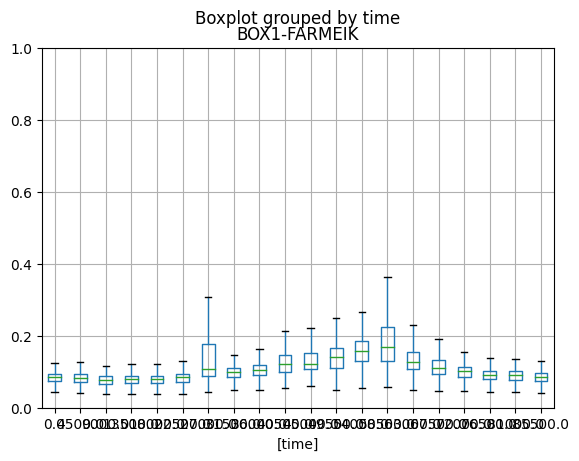

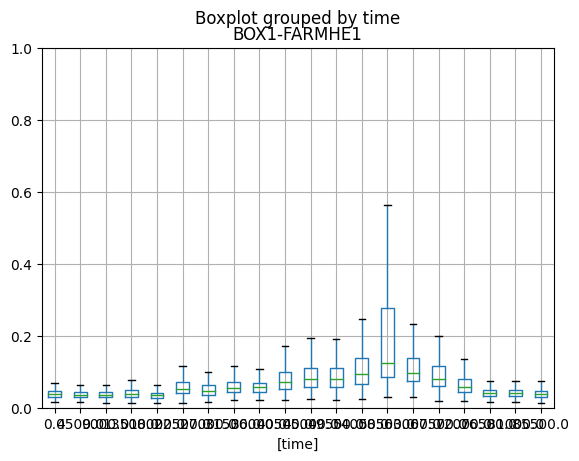

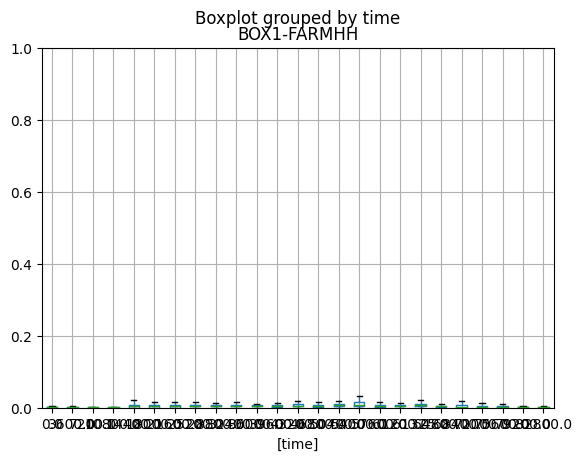

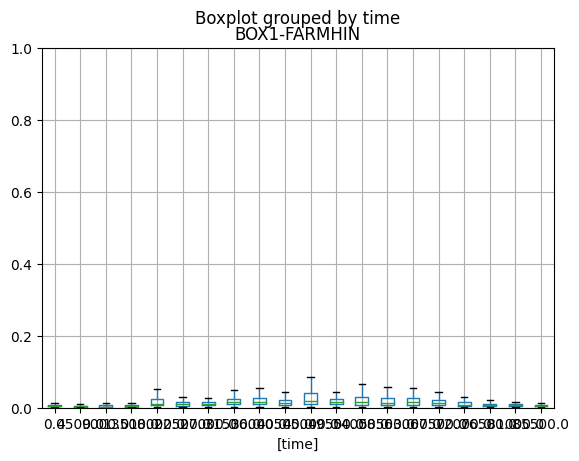

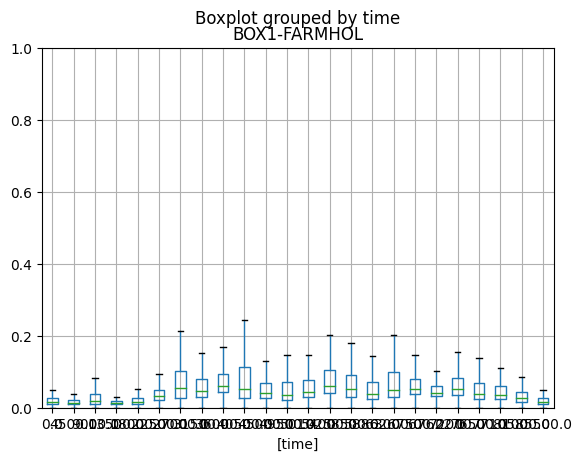

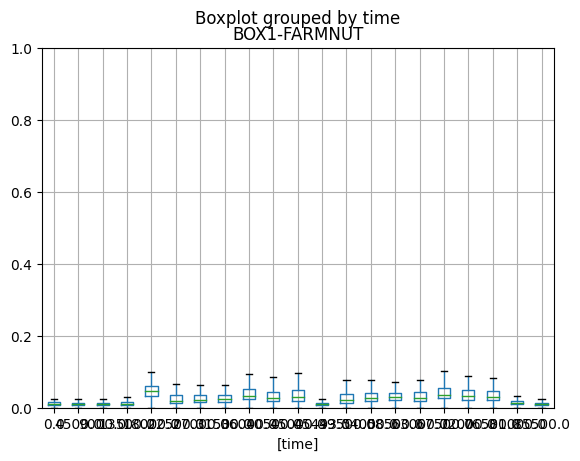

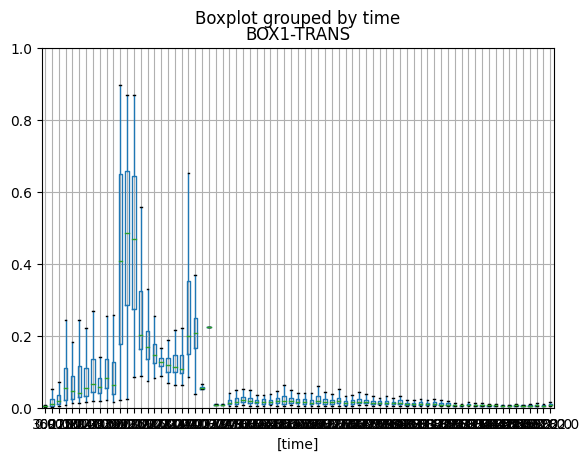

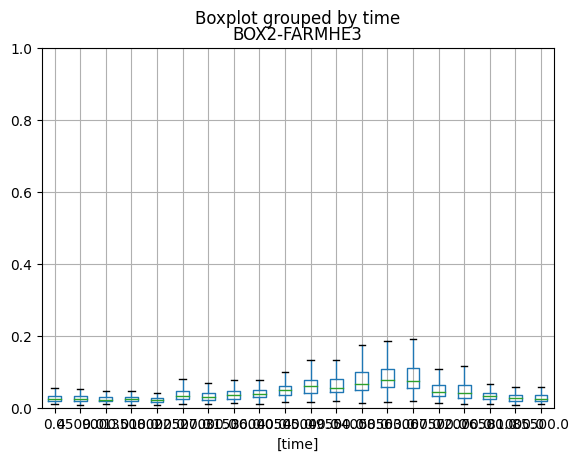

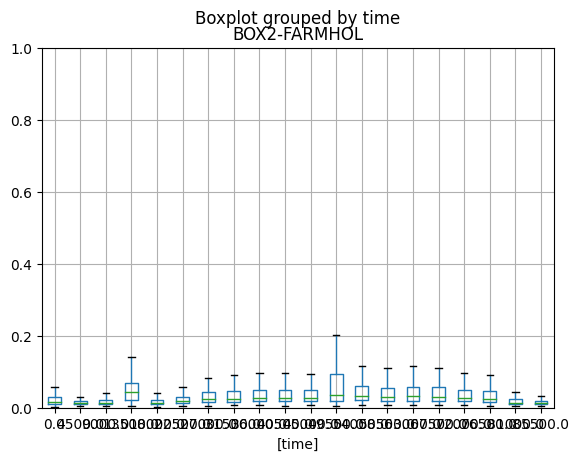

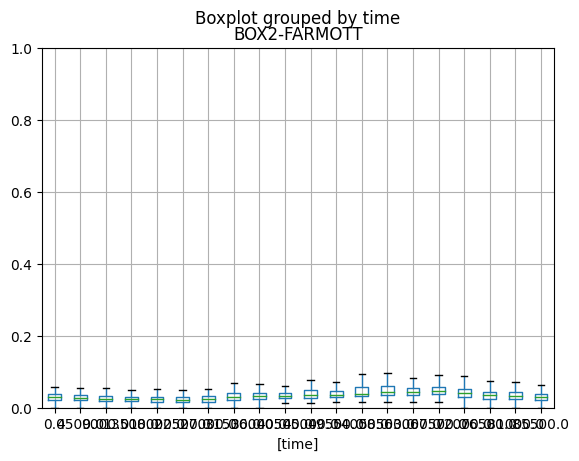

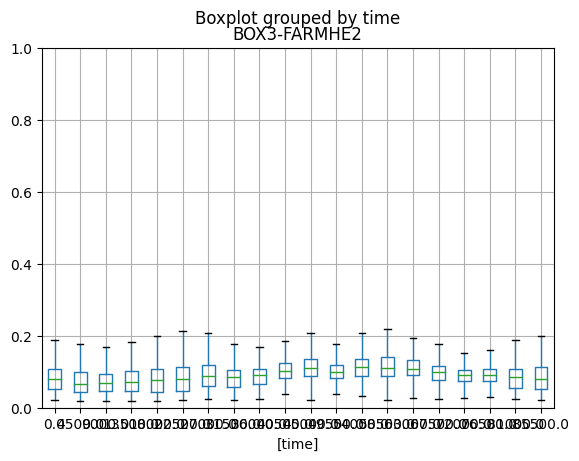

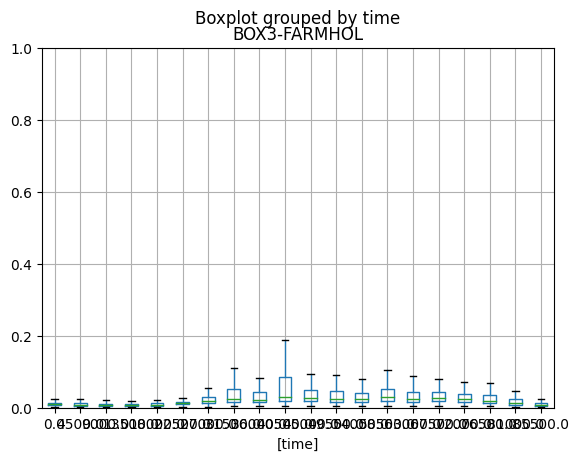

In [69]:
for farm in pd.unique(farm_time['farm']):
    full_rms[full_rms['farm'] == farm].boxplot(by='time', showfliers=False)
    plt.ylim(0, 1)
    plt.title(farm)
    plt.savefig(f"/home/poulpos/pigs-documentary/plot/rms/{farm}.pdf")

In [12]:
full_sat = pd.DataFrame(columns=["farm", "time", "sat"])
sr = 44100
for _, row in df.iterrows():
    cur_sat = pd.read_csv(os.path.join(bp_path, row['farm'], 'saturation', row['file'] + '.csv'))
    cur_sat['duration'] = (cur_sat['end_in_nof'] - cur_sat['start_in_nof']) / sr
    full_sat = pd.concat([full_sat,
                          pd.DataFrame(data={'farm': [row['farm']],
                                            'time': [row['time']],
                                            'sat': [cur_sat['duration'].sum()]})], ignore_index=True)

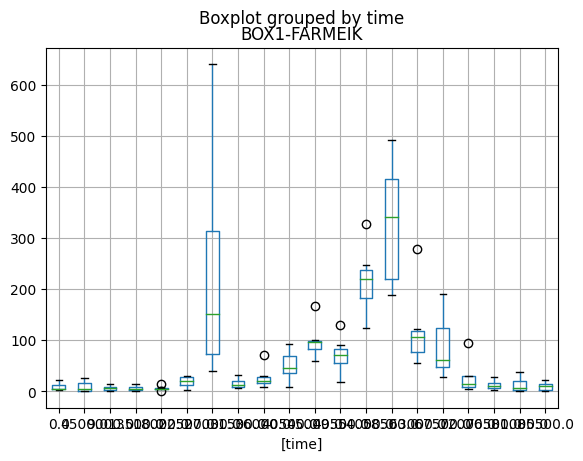

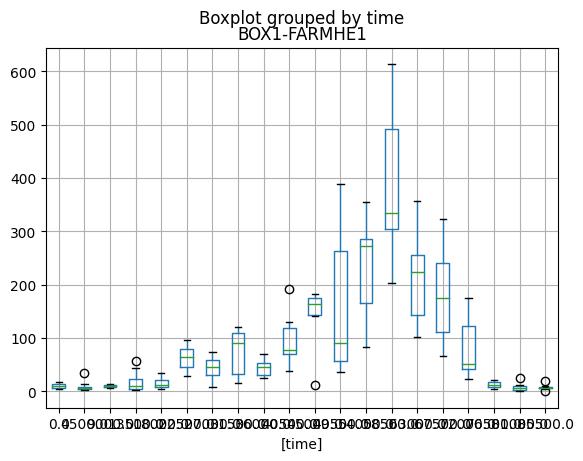

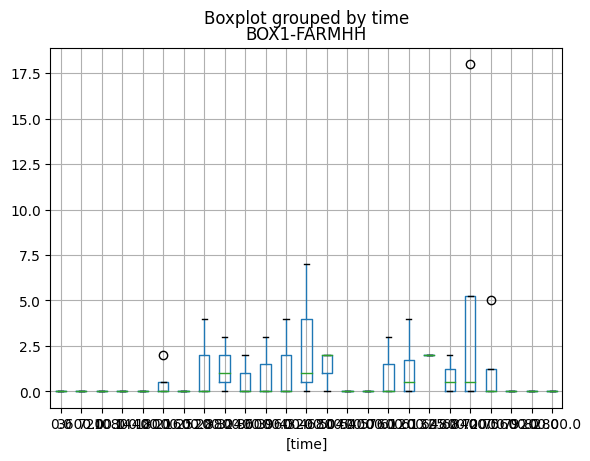

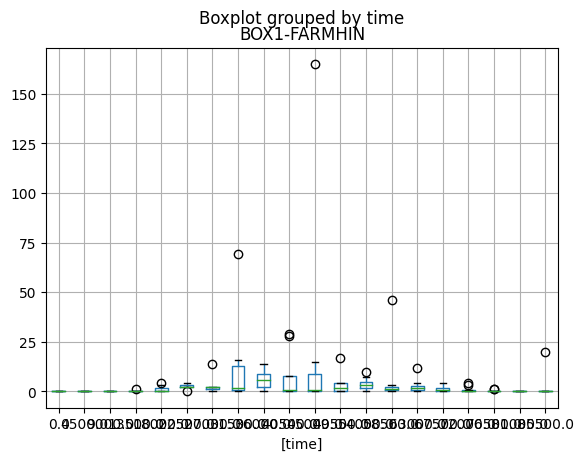

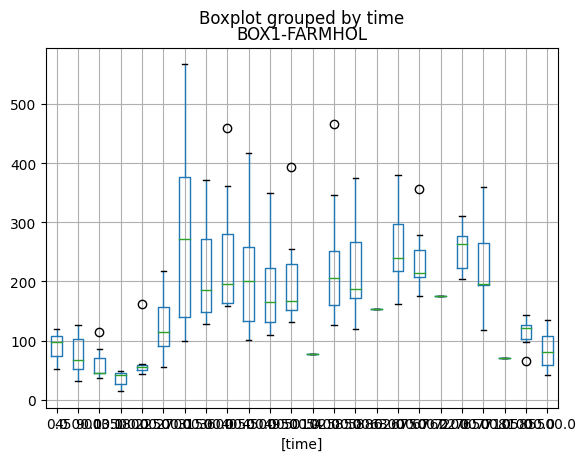

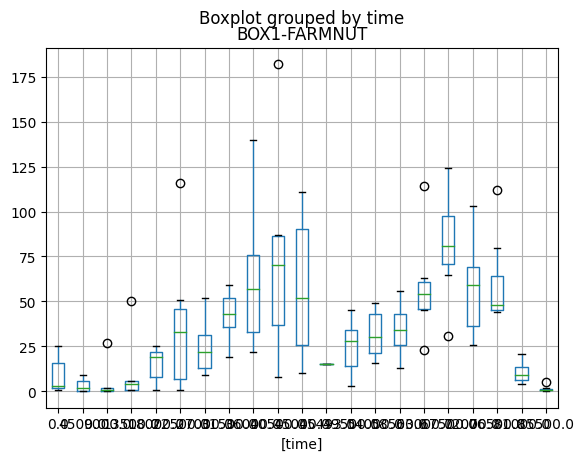

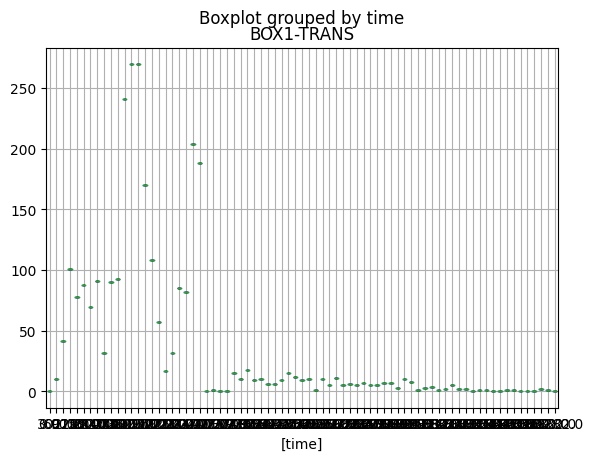

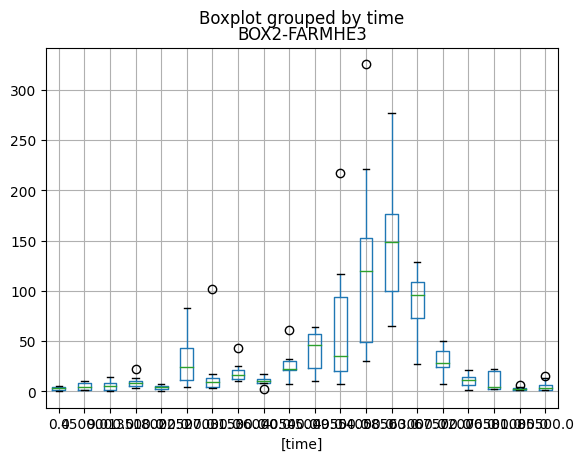

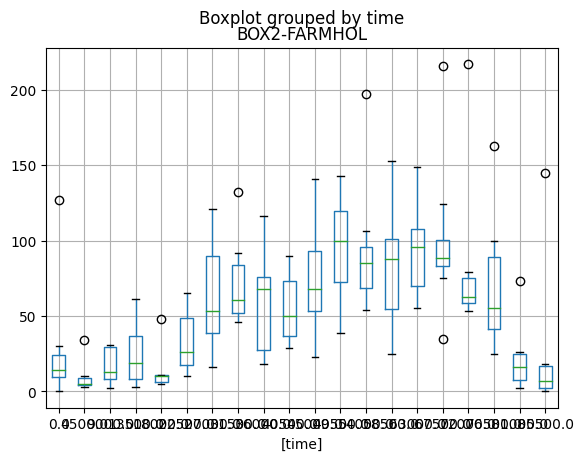

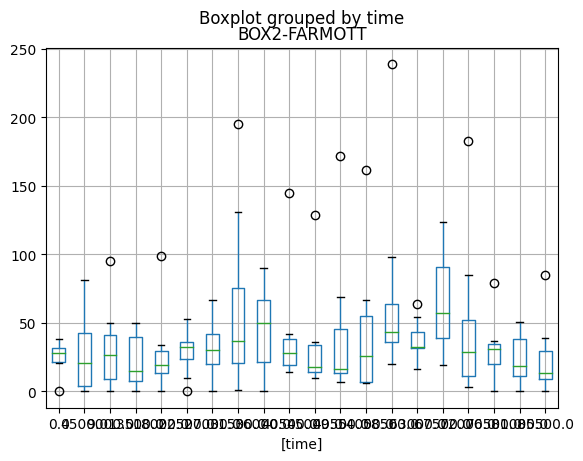

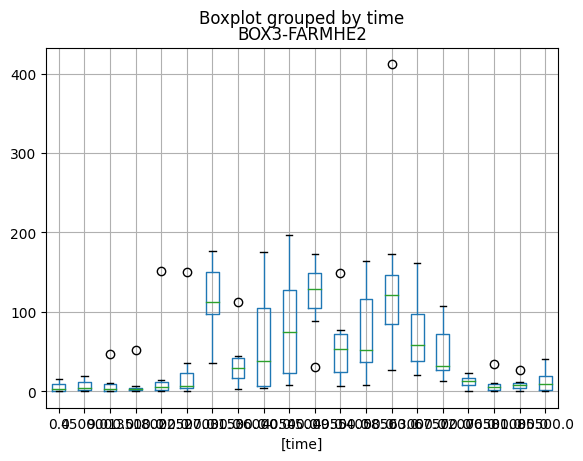

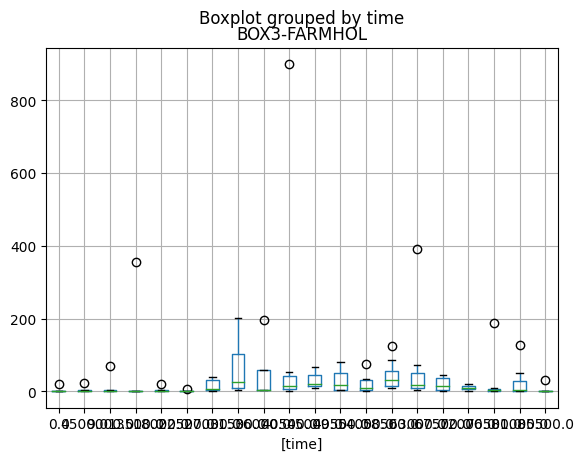

In [15]:
for farm in pd.unique(farm_time['farm']):
    full_sat[full_sat['farm'] == farm].boxplot(by='time')
    plt.title(farm)
    plt.savefig(f"/home/poulpos/pigs-documentary/plot/saturation/{farm}.pdf")

# Notes

## Data

- `raw/BOX2-FARMHOL` and `Ciara Backed Up/Box2-SDCard-X280` is the same data
- `raw/BOX3-FARMHOL` and `Ciara Backed Up/Box3-SDCard-X252` is the same data
- `BOX1-FARMHOL`: there is one 13:55:02 and one 16:21:02

The almost fully saturated recordings from the transport are still apart, in `raw/BOX1-TRANS/saturated`

### Thoughts

### Biases due to saturation

We may also bias the study when we remove saturated regions: there are often due to high-frequency calls.

### Background

In addition there is a great variation of background noise, in the same farm, across time.

### Learning

Is there an issue with teaching to recognize farm noises, for instance a pig hitting a metal bar?

If we have such a category, and there is an excerpt with call + farm noise, will we see it in the scores associated with each category?

### ANIMAL-SPOT

- noise augmentation?
    - there is a module in AS
- who takes care of normalization?
    - AS does
- `num_workers`?
- `filter_broken_audio`: minimum loudness?
- `sequence_length`: how is done the subsampling?
- To Ave: `fmin` `fmax` `sequence_length` `fft` parameters ? 
- ERDA
    - cache `/tmp`
    - how many threads/cores?

To be checked:

- data augmentation in AS: 1 input data -> 1 training data or several?

#### Training

- the training dataset is composed of constant-size excerpts
- how do we make a balanced training noise dataset?
    - ratio on every kind of background, then draw (with replacement if not enough)?
- noise augmentation from the same dataset as the noise training?

### Specificities of the recordings

#### `BOX1-FARMHOL_20230606_0730`: distinguish farm metal claps from calls 

  | type | steady-state | saturation | delta (ms) |
  | --- | ----------- | --------- | ----- |
  | clap | 2'22''135 | 2'22''143 | 8 |
  | bounce | 2'22''587 | 2'22''603 | 16 |
  | call | 2'24''791 | 2'24''837 | 46 |
  | HF call | 2'19''024 | 2'19''046 | 22 |
  | call | 2'28''869 | 2'28''910 | 41 |
  
  `*_0730` mostly claps, `_1330` too, but still some ugly HF calls that get saturated

  
#### `BOX1-FARMHH`

- low gain
- a lot of birds
- not many calls
- I did not hear any HF, only rare grunts

    
#### `BOX2-FARMHOL`
- construction work? 06/05 13:45 0'11
- machines? 06/07 07:30 4'30
- no metal bars; saturation because of HF calls, usually not long
- some door openings? 21:15
- snoring? 06/07 00:00 9'40
- more activity than others during the night?

#### `BOX2-FARMOTT`
- snoring? 06/24 08:45
- 08:45, 05:00, 18:45
    - a lot of consecutive saturated barking, sometimes a dialogue
    - saturation barkling and sometimes HF long calls
- very few metal sounds

#### `BOX3-FARMHOL`
- low gain
- 0:00 door openings, long overlapping calls, a bit far
- 8:45 a lot of door openings, though not saturated
- 06/08 08:45 0' people
- 06/08, 06/09 engines (saturated)
- 06/06 11:15 TO BE DISCARDED (fully saturated) (started at the end of 10:00)
- 11:15 some door openings, engines (06/07, ...), saturated HF calls (06/10 9'07''7)
- 16:15 door openings, saturated HF

#### `BOX1-FARMEIK`
- high intensity background
- not sure we can use that; almost every sound event is saturated
- both doors and calls saturate (08/02 07:30 6'15 6'23), but mostly calls
- fights (saturated)? 08/06 07:30 8', 08/08 07:30 3'45
- 16:15 many saturated HF (or not) (overlapping) calls

#### `BOX1-FARMHE1`
- 0:00 saturated and non-saturated claps
- 08/13 16:15 WRONG OFFSET
- 16:15 many many saturated long HF calls. Non-saturated are very few
- 11:15 lower pitch, still often saturated

#### `BOX1-FARMHIN`
- a lot of birds
- rain on 07/16
- saturation: rain, wind, HF calls (long and short), construction
- 05:00 a lot of clean birds
- 08:45
    - some saturated short HF calls (07/15)
    - some saturated wind (07/16)
    - saturated thunderstorm and rain (07/17)
    - overlapping calls and birds, + food or water (I guess there is a pond)? (07/19)
- should we have a background of singing birds?
- 11:15 saturated calls and doors (07/16)
- 12:30 saturated construction work and calls (07/17), saturated rain (07/16)

#### `BOX1-FARMHOL`
- a lot of saturated bang
- often: machine background, e.g. 06/11 15:00 10'58
- saturated HF calls too
- 07:30 construction or engine 06/06, 06/07 and 06/08 (+ always bangs)
- 15:00 machine
- machine background, e.g. 06/11 15:00 0'40

#### `BOX1-FARMNUT`
- 00:00
    - sometimes saturated (HF calls and claps)
    - 06/21 8'44 snoring
    - 06/20 good background? (with some snoring)
- 06:15
    - many birds, many saturations
    - hard to find good things to label
- 11:15
    - gain too high
    - noisy, clicks saturated calls
    - 06/15
- 18:45
    - machine background: 06/15 06/17 06/20
    - more HF calls

#### `BOX2-FARMHE3`
- everything seems far
- 01:15
    - 08/09 snoring
    - 08/12 grinder
- 06:15
    - many saturated claps, saturated calls (08/15)
- 13:45, 16:15
    - many saturated long HF calls (e.g. 08/13 9'), some satrated claps

#### `BOX2-FARMHE3`
- 02:30 08/16 perfect for background (three clean levels)
- some deep breathing (e.g. 08/09 10'30)
- some saturated short repetitive calls
- mostly saturated because of long (HF) calls

#### `BOX1-TRANS`
- calls I never heard before: short HF panting, e.g. 20:43 2'02
- cat at least from 23:33
- saturation both calls and noises (e.g. 00:25)
- from 05:50 background level very high


#### To be labeled?

- ++ `BOX1-FARMHIN` 07/16 08:45
- m  `BOX1-FARMHIN` 07/19 08:45 between the birds
- `+` `BOX1-FARMHIN` 07/13 11:15 background noise but nice calls
- m `BOX1-FARMHIN` 07/18 12:30 some short calls at the end
- m `BOX1-FARMHIN` 07/14 18:45 good LF calls except the birds...
- `+` `BOX1-FARMHOL` 06/10 01:15
- `+` `BOX1-FARMHOL` 06/10 07:30 variety of calls, saturated or not
- `--` `BOX1-FARMHOL` 06/12 07:30 some overlapping calls maybe around 13'30?
- `-` `BOX1-FARMHOL` 06/07 15:00 very saturated, but bangs sometimes stop?
- `+` `BOX1-FARMNUT` 06/16 00:00 variety of calls
- `-` `BOX1-FARMNUT` 06/15 11:15 good activity
- m `BOX2-FARMHE3` 08/10 13:45 coughing, barkling, long HF calls
- m `BOX3-FARMHE2` 08/10 02:30 short repetitive calls (saturated and not saturated), but loud background (in comparison)
- m `BOX3-FARMHE2` 08/09 or 08/10 08:45 long calls (saturated and not saturated), and shorter calls
- `++` `BOX1-TRANS` 00:00

## Technicals

### Appending a simple row to a dataframe...

In [9]:
pouet = pd.DataFrame(columns=["truc", "machin"])
s = pd.Series({"truc":2, "machin":"eri"})
pouet = pd.concat([pouet, s.to_frame().T], ignore_index=True)
pouet.head()
s["truc"] = 23
pouet = pd.concat([pouet, s.to_frame().T], ignore_index=True)
pouet.head()

truc machin
0    2    eri
1   23    eri

# Trash

## Batch with Essentia

In [17]:
from IPython.display import Audio
from essentia.standard import MonoLoader, SaturationDetector, FrameGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob
import pandas as pd
import datetime

In [18]:
# data_path = "/run/media/poulpos/PIGS-KU-BU1/cleaned"
# data_path = "/run/media/poulpos/PIGS-KU-BU1/Ciara Backed Up/"
data_path = "/run/media/poulpos/PIGS-KU-BU1/raw/BOX1-TRANS"
agg_path = "/home/poulpos/pigs-documentary/data"

In [19]:
sr = 44100
frame_size = 512
hop_size = 256

In [20]:
df = pd.DataFrame(columns=["farm", "filename", "saturated", "total"])

# farms = ["BOX1-FARMHH", "BOX2-FARMOTT", "BOX1-FARMHOL", "BOX3-FARMHOL", "BOX2-FARMHOL", "BOX1-FARMNUT", "BOX1-TRANS"] # 
# farms = ["BOX1-FARMEIK", "BOX1-FARMHE1", "BOX1-FARMHIN", "BOX2-FARMHE3", "BOX3-FARMHE2"]
farms = ["saturated"]

issues = []
farm_time = []
for ifarm, farm in enumerate(farms):
    beg = datetime.datetime.now()
    print("Farms before: ")
    for ft in farm_time:
        print(ft, end=", ")
    print()
    print(f"{farm}; start: {beg}")
    
    folder = os.path.join(data_path, farm)
    files = glob.glob("*.wav", root_dir=folder)
    for ifile, file in enumerate(files):
        audio_file = os.path.join(folder, file)

        try:
            audio = MonoLoader(filename=audio_file, sampleRate=sr)()
        except:
            issues.append(file)
            continue
        time = np.arange(len(audio)) / sr
    
        saturationDetector = SaturationDetector(frameSize=frame_size,
                                            hopSize=hop_size)
    
        starts, ends = [], []
        for frame in FrameGenerator(audio,
                                    frameSize=frame_size,
                                    hopSize=hop_size,
                                    startFromZero=True):
            frame_starts, frame_ends = saturationDetector(frame)
            starts.extend(frame_starts)
            ends.extend(frame_ends)
    
        frame_duration = 1
    
        ise = 0
        residual = 0
        n_frame = math.ceil(time[-1] / frame_duration)
        rate = n_frame * [0]
        
        for f in range(n_frame):
            current = 0
            end_frame = (f + 1) * frame_duration
            while ise < len(starts) and ends[ise] <= end_frame:
                current += ends[ise] - starts[ise]
                ise += 1
            if ise < len(starts) and starts[ise] <= end_frame:
                current += end_frame - starts[ise]
                starts[ise] = end_frame
            else:
                ise += 1
            rate[f] = current / frame_duration
    
        per_file = (datetime.datetime.now() - beg) / (ifile + 1)

        
        print(f"{datetime.datetime.now()} | {file} ({ifile+1}/{len(files)}) | ETA: {beg + per_file*len(files)}", end="\r")
        
        df = pd.concat([df, pd.DataFrame(data={
            "farm": [farm],
            "filename":[file],
            "saturated": [len([r for r in rate if r > 0])],
            "total":[n_frame]})], ignore_index=True)

    df.to_csv(os.path.join(agg_path, "saturation-transport.csv"), index=False)
    farm_time.append(datetime.datetime.now() - beg)

Farms before: 

saturated; start: 2023-09-07 11:45:13.137421


In [21]:
df

farm                        filename saturated total
0   saturated  BOX1-TRANS_20230626_010502.wav       278   298
1   saturated  BOX1-TRANS_20230626_011002.wav       297   298
2   saturated  BOX1-TRANS_20230626_011502.wav       288   298
3   saturated  BOX1-TRANS_20230626_012002.wav       298   298
4   saturated  BOX1-TRANS_20230626_012502.wav       294   298
5   saturated  BOX1-TRANS_20230626_013002.wav       290   298
6   saturated  BOX1-TRANS_20230626_013502.wav       297   298
7   saturated  BOX1-TRANS_20230626_014002.wav       296   298
8   saturated  BOX1-TRANS_20230626_014502.wav       290   298
9   saturated  BOX1-TRANS_20230626_015002.wav       270   298
10  saturated  BOX1-TRANS_20230626_015502.wav       245   298
11  saturated  BOX1-TRANS_20230626_020002.wav       250   298
12  saturated  BOX1-TRANS_20230626_020502.wav        81   298
13  saturated  BOX1-TRANS_20230626_021002.wav        56   298
14  saturated  BOX1-TRANS_20230626_021502.wav       177   298
15  saturated  BOX1-TRANS_20230626_022002.wav       191   298
16  saturated  BOX1-TRANS_20230626_022502.wav       237   298
17  saturated  BOX1-TRANS_20230626_023002.wav       219   298
18  saturated  BOX1-TRANS_20230626_023502.wav       189   298
19  saturated  BOX1-TRANS_20230626_024002.wav       284   298
20  saturated  BOX1-TRANS_20230626_024502.wav       289   298
21  saturated  BOX1-TRANS_20230626_025002.wav       298   298
22  saturated  BOX1-TRANS_20230626_025502.wav       298   298
23  saturated  BOX1-TRANS_20230626_030002.wav       298   298
24  saturated  BOX1-TRANS_20230626_030502.wav       298   298
25  saturated  BOX1-TRANS_20230626_031002.wav       298   298
26  saturated  BOX1-TRANS_20230626_031502.wav       298   298
27  saturated  BOX1-TRANS_20230626_032002.wav       298   298
28  saturated  BOX1-TRANS_20230626_032502.wav       298   298
29  saturated  BOX1-TRANS_20230626_033002.wav       298   298
30  saturated  BOX1-TRANS_20230626_033502.wav       298   298
31  saturated  BOX1-TRANS_20230626_034002.wav       230   298
32  saturated  BOX1-TRANS_20230626_034502.wav       228   298
33  saturated  BOX1-TRANS_20230626_035002.wav       191   298
34  saturated  BOX1-TRANS_20230626_035502.wav       298   298
35  saturated  BOX1-TRANS_20230626_040002.wav       298   298
36  saturated  BOX1-TRANS_20230626_040502.wav       298   298
37  saturated  BOX1-TRANS_20230626_041002.wav       298   298
38  saturated  BOX1-TRANS_20230626_041502.wav       298   298
39  saturated  BOX1-TRANS_20230626_042002.wav       298   298
40  saturated  BOX1-TRANS_20230626_042502.wav       298   298
41  saturated  BOX1-TRANS_20230626_043002.wav       298   298
42  saturated  BOX1-TRANS_20230626_043502.wav       298   298
43  saturated  BOX1-TRANS_20230626_044002.wav       298   298
44  saturated  BOX1-TRANS_20230626_044503.wav       296   297
45  saturated  BOX1-TRANS_20230626_045002.wav       298   298
46  saturated  BOX1-TRANS_20230626_045502.wav       298   298
47  saturated  BOX1-TRANS_20230626_050002.wav       298   298
48  saturated  BOX1-TRANS_20230626_050502.wav       298   298
49  saturated  BOX1-TRANS_20230626_051002.wav       296   298
50  saturated  BOX1-TRANS_20230626_051502.wav       298   298
51  saturated  BOX1-TRANS_20230626_052002.wav       298   298
52  saturated  BOX1-TRANS_20230626_052502.wav       274   298
53  saturated  BOX1-TRANS_20230626_053002.wav       296   298
54  saturated  BOX1-TRANS_20230626_053502.wav       294   298
55  saturated  BOX1-TRANS_20230626_054002.wav       291   298
56  saturated  BOX1-TRANS_20230626_054502.wav       298   298

In [14]:
issues

[]

In [15]:
df["saturated"].sum()

21718

In [22]:
21718/3600

6.032777777777778

In [53]:
df.to_csv(os.path.join(data_path, "saturation.csv"), index=False)

In [4]:
df = pd.DataFrame(columns=["farm", "filename", "saturated", "total"])

In [8]:
farms = ["BOX1-FARMHOL", "BOX3-FARMHOL", "BOX2-FARMHOL", "BOX1-FARMNUT", "BOX1-TRANS"]
for i,f in enumerate(farms):
    print(i, end="")
    print(f)

0BOX1-FARMHOL
1BOX3-FARMHOL
2BOX2-FARMHOL
3BOX1-FARMNUT
4BOX1-TRANS


In [19]:
p = datetime.datetime.now()

In [20]:
print(datetime.datetime.now()-p)

0:00:10.715310


In [16]:
SaturationDetector?

Init signature: SaturationDetector(**kwargs)
Docstring:     
SaturationDetector


Inputs:

  [vector_real] frame - the input audio frame


Outputs:

  [vector_real] starts - starting times of the detected saturated regions [s]
  [vector_real] ends - ending times of the detected saturated regions [s]


Parameters:

  differentialThreshold:
    real ∈ [0,inf) (default = 0.0010000000475)
    minimum difference between contiguous samples of the salturated regions

  energyThreshold:
    real ∈ (-inf,0] (default = -1)
    mininimum energy of the samples in the saturated regions [dB]

  frameSize:
    integer ∈ (0,inf) (default = 512)
    expected input frame size

  hopSize:
    integer ∈ (0,inf) (default = 256)
    hop size used for the analysis

  minimumDuration:
    real ∈ [0,inf) (default = 0.00499999988824)
    minimum duration of the saturated regions [ms]

  sampleRate:
    real ∈ (0,inf) (default = 44100)
    sample rate used for the analysis


Description:

  this algorithm output